<p align="center">
  <img height="100" src="https://raw.githubusercontent.com/arguflow/blog/5ef439020707b0e27bf901c8f6b4fb1f487a78d4/apps/frontend/public/assets/horizontal-logo.svg" alt="Arguflow">
</p>

<p align="center">
    <b>Offering a product suite for putting arbitrary models into production semantic search and retrieval-augmented LLM-chat experiences on your company's data</b>
</p>

<p align="center">
<strong><a href="https://docs.arguflow.ai">Documentation</a> • <a href="https://search.arguflow.ai">Competitive Debate Search Demo</a> • <a href="https://chat.arguflow.ai">Competitive Debate Chat Demo</a> • <a href="https://discord.gg/CuJVfgZf54">Discord</a>

</strong>
</p>


# Pgvector and lanterndb are now nearly as fast and just as accurate as a SVD (Qdrant)

The objective behind this notebook was to assess the feasibility of substituting our system's SVD, [Qdrant](https://qdrant.tech/), with [pgvector](https://github.com/pgvector/pgvector) or [lanterndb](https://lantern.dev/) - AKA postgresql + [usearch](https://www.unum.cloud/). Employing an OLTP solution like these postgresql focused ones would offer the advantage of utilizing a transactional database with schema and transaction support for both objects and vectors, thereby eliminating the need for external database joins during diverse search operations.

## Star us on Github at [github.com//arguflow/arguflow](https://github.com/arguflow/arguflow)!!!!

<img src="./images/please-star-us.png" alt="star-please" width="330px"/>

## Findings

Both [pgvector](https://github.com/pgvector/pgvector) and [lanterndb](https://lantern.dev/) are **nearly as fast** relative to [Qdrant](https://qdrant.tech/) and **can** be **equally accurate** after tuning. This means that you should first place your vectors in both [Qdrant](https://qdrant.tech/) and [pgvector](https://github.com/pgvector/pgvector) or [lanterndb](https://lantern.dev/) then tweak your HNSW index params, `m` and `ef_construction`, such that the postgres solution is just as accurate as [Qdrant](https://qdrant.tech/). Following that, move forward with postgres alone.

If you are not already using postgres and do not have requirements for an ACID compliant solution, then we would still recommend [Qdrant](https://qdrant.tech/). It has a lot of convience features, supports quantization, and does not require tuning to be accurate. 

### Speed Comparisons

![pgsolutions vs qdrant](./images/speed-comparison.png)

### Accuracy comparisons

![pgvector accuracy](./images/pgvector-accuracy.png)

![lanterndb accuracy](./images/lanterndb-accuracy.png)


### Replicating our results
1. Download the dataset via [this link](https://drive.proton.me/urls/FED1ABWG70#ItjHZqiPpUao). This is roughly the [DebateSum dataset](https://aclanthology.org/2020.argmining-1.1/), but with some improved parsing loggic and dedup detection as noted on [our docs](https://docs.arguflow.ai).
2. Place the dataset into the same directory as this notebook
3. `docker compose up -d`
4. `cat .env.dist > .env`
4. Run all to duplicate our findings

In [4]:
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http import models

# Load values from the .env file
load_dotenv()

True

In [7]:
# Get values from the environment variables
qdrant_url = os.getenv("QDRANT_URL")
qdrant_api_key = os.getenv("QDRANT_API_KEY")

# Create the QdrantClient instance
qdrant_client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key,
)

qdrant_client.recreate_collection(
    collection_name="debate_cards",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE),
)

/home/skeptrune/git_projects/arguflow/pgvector-vs-qdrant-comparison/.venv/lib/python3.10/site-packages/qdrant_client/qdrant_remote.py:115: UserWarning: Api key is used with unsecure connection.
  warnings.warn("Api key is used with unsecure connection.")


In [13]:
import pickle

# Load the dataset from the pickle file
pickle_filename = "dataset.pickle"
with open(pickle_filename, "rb") as pickle_file:
    loaded_dataset = pickle.load(pickle_file)


In [6]:
qdrant_count = qdrant_client.count(
    collection_name="debate_cards",
    exact=True,
)

if qdrant_count.count > 0:
    print("Collection is not empty, exiting")
else:
    # add to qdrant 1k at a time
    for i in range(0, len(loaded_dataset), 1000):
        qdrant_client.upsert(
            collection_name="debate_cards",
            points=models.Batch(
                ids=[item[0] for item in loaded_dataset[i:i+1000]],
                vectors=[item[1] for item in loaded_dataset[i:i+1000]]
            ),
        )

qdrant_client.count(
    collection_name="debate_cards",
    exact=True,
)

Collection is not empty, exiting


CountResult(count=255070)

In [5]:
import psycopg2

pgvector_url = os.getenv("PGVECTOR_URL")
lanterndb_url = os.getenv("LANTERNDB_URL")

pgvector_connection = psycopg2.connect(pgvector_url)
lanterndb_connection = psycopg2.connect(lanterndb_url)

pgvector_cursor = pgvector_connection.cursor()
lanterndb_cursor = lanterndb_connection.cursor()

In [37]:
lanterndb_cursor.execute("CREATE EXTENSION lantern;")
lanterndb_cursor.execute("set enable_seqscan = false;")
lanterndb_connection.commit()

pgvector_cursor.execute("CREATE EXTENSION vector;")
pgvector_cursor.execute("set enable_seqscan = false;")
pgvector_connection.commit()

In [2]:
m_ef_pairs = [(8, 32), (16, 64), (32, 128), (40, 160)]

In [9]:
# 94mins 26sec

for m, ef in m_ef_pairs:
    delete_table_query = f"DROP TABLE IF EXISTS qdrant_vectors_{m}_{ef};"
    pgvector_cursor.execute(delete_table_query)
    pgvector_connection.commit()
    lanterndb_cursor.execute(delete_table_query)
    lanterndb_connection.commit()

    pgvector_create_table_query = f"""
        CREATE TABLE qdrant_vectors_{m}_{ef} (
            point_id TEXT PRIMARY KEY,
            embedding vector(1536)
        );
    """
    pgvector_cursor.execute(pgvector_create_table_query)
    pgvector_connection.commit()

    lantern_create_table_query = f"""
        CREATE TABLE qdrant_vectors_{m}_{ef} (
            point_id TEXT PRIMARY KEY,
            embedding real[1536]
        );
    """
    lanterndb_cursor.execute(lantern_create_table_query)
    lanterndb_connection.commit()

    if (m, ef) == m_ef_pairs[0]:
        offset = ""
        while offset is not None:
            scroll_result = qdrant_client.scroll(
                collection_name="debate_cards",
                limit=1,
                with_vectors=True,
                offset=(offset if offset else None),
            )

            offset = scroll_result[1]

            if scroll_result[0]:  # Check if there are points to insert
                insert_found_points_query = f"""
                    INSERT INTO qdrant_vectors_{m}_{ef} (point_id, embedding)
                    VALUES
                """

                values = []
                for point in scroll_result[0]:
                    values.append((point.id, point.vector))

                placeholders = ",".join(["(%s, %s)"] * len(values))
                insert_found_points_query += placeholders

                pgvector_cursor.execute(
                    insert_found_points_query,
                    [item for sublist in values for item in sublist],
                )
                pgvector_connection.commit()
                lanterndb_cursor.execute(
                    insert_found_points_query,
                    [item for sublist in values for item in sublist],
                )
                lanterndb_connection.commit()
            
        continue
    
    copy_first_m_ef_query = f"""
        INSERT INTO qdrant_vectors_{m}_{ef}
        SELECT * FROM qdrant_vectors_{m_ef_pairs[0][0]}_{m_ef_pairs[0][1]};
    """
    pgvector_cursor.execute(copy_first_m_ef_query)
    pgvector_connection.commit()
    lanterndb_cursor.execute(copy_first_m_ef_query)
    lanterndb_connection.commit()

        


In [5]:
# 496mins

# create indices
for m, ef in m_ef_pairs:
    pgvector_hnsw_query = f"""
        CREATE INDEX ON qdrant_vectors_{m}_{ef} USING hnsw (embedding vector_cosine_ops) WITH (m = {m}, ef_construction = {ef});
    """
    pgvector_cursor.execute(pgvector_hnsw_query)
    pgvector_connection.commit()

    lantern_hnsw_query = f"""
        CREATE INDEX ON qdrant_vectors_{m}_{ef} USING hnsw (embedding dist_cos_ops) WITH (M={m}, ef_construction={ef}, ef={100}, dim=1536);
    """
    lanterndb_cursor.execute(lantern_hnsw_query)
    lanterndb_connection.commit()



In [9]:
scroll_result = qdrant_client.scroll(
    collection_name="debate_cards",
    limit=100,
    with_vectors=True,
)

first_100_qdrant_vectors = [point.vector for point in scroll_result[0]]

In [7]:
for m, ef in m_ef_pairs:
    index_query = f"""
    SELECT indexname
    FROM pg_indexes
    WHERE tablename = 'qdrant_vectors_{m}_{ef}';
    """
    pgvector_cursor.execute(index_query)
    pgvector_index_names = pgvector_cursor.fetchall()
    print("pgvector indices:", pgvector_index_names)

    lanterndb_cursor.execute(index_query)
    lanterndb_index_names = lanterndb_cursor.fetchall()
    print("lanterndb indices:", lanterndb_index_names)

pgvector indices: [('qdrant_vectors_8_32_pkey',), ('qdrant_vectors_8_32_embedding_idx',)]
lanterndb indices: [('qdrant_vectors_8_32_pkey',), ('qdrant_vectors_8_32_embedding_idx',)]
pgvector indices: [('qdrant_vectors_16_64_pkey',), ('qdrant_vectors_16_64_embedding_idx',)]
lanterndb indices: [('qdrant_vectors_16_64_pkey',), ('qdrant_vectors_16_64_embedding_idx',)]
pgvector indices: [('qdrant_vectors_32_128_pkey',), ('qdrant_vectors_32_128_embedding_idx',)]
lanterndb indices: [('qdrant_vectors_32_128_pkey',), ('qdrant_vectors_32_128_embedding_idx',)]
pgvector indices: [('qdrant_vectors_40_160_pkey',), ('qdrant_vectors_40_160_embedding_idx',)]
lanterndb indices: [('qdrant_vectors_40_160_pkey',), ('qdrant_vectors_40_160_embedding_idx',)]


In [8]:
import numpy as np
import timeit

qdrant_search_times = []
pg_results_dict = {}
for m, ef in m_ef_pairs:
    pg_results_dict[(m, ef)] = {}
    pg_results_dict[(m, ef)]["pgvector"] = []
    pg_results_dict[(m, ef)]["lanterndb"] = []


for m, ef in m_ef_pairs:
    for i in range(100):
        query_vector = np.random.rand(1536).astype(np.float32).tolist()
        lanterndb_query_vector = str(query_vector).replace("[", "{").replace("]", "}")

        pgvector_cosine_similarity_query = f"""
        SELECT
            point_id,
            1 - (embedding <=> '{query_vector}') AS cosine_similarity
        FROM qdrant_vectors_{m}_{ef}
        ORDER BY embedding <=> '{query_vector}'
        LIMIT 10;
        """

        lanterndb_consine_similarity_query = f"""
        SELECT
            point_id,
            1 - cos_dist(embedding, '{lanterndb_query_vector}') AS cosine_similarity
            FROM qdrant_vectors_{m}_{ef}
        ORDER BY embedding <-> '{lanterndb_query_vector}'
        LIMIT 10;
        """

        def query_pgvector():
            pgvector_cursor.execute(pgvector_cosine_similarity_query)
            pgvector_cursor.fetchall()
            pgvector_connection.commit()
        
        def query_lanterndb():
            lanterndb_cursor.execute(lanterndb_consine_similarity_query)
            lanterndb_cursor.fetchall()
            lanterndb_connection.commit()

        pgvector_time = timeit.timeit(query_pgvector, number=1)
        lanterndb_time = timeit.timeit(query_lanterndb, number=1)
        pg_results_dict[(m, ef)]["pgvector"].append(pgvector_time)
        pg_results_dict[(m, ef)]["lanterndb"].append(lanterndb_time)

        if (m, ef) == m_ef_pairs[0]:
            qdrant_search_times.append(timeit.timeit(lambda: qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10), number=1))

    

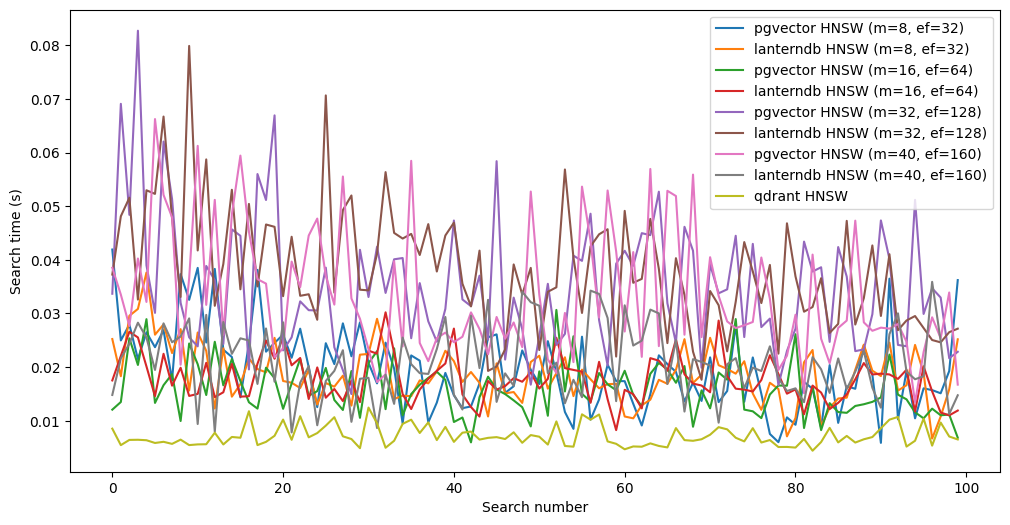

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for m, ef in m_ef_pairs:
    plt.plot(pg_results_dict[(m, ef)]["pgvector"], label=f"pgvector HNSW (m={m}, ef={ef})")
    plt.plot(pg_results_dict[(m, ef)]["lanterndb"], label=f"lanterndb HNSW (m={m}, ef={ef})")

plt.plot(qdrant_search_times, label="qdrant HNSW")

plt.xlabel("Search number")
plt.ylabel("Search time (s)")
plt.legend()
plt.show()

In [21]:
for m, ef in m_ef_pairs:
    print(f"m={m}, ef={ef}")
    print(f"pgvector avg search time: {np.mean(pg_results_dict[(m, ef)]['pgvector'])}s")
    print(f"pgvector max search time: {np.max(pg_results_dict[(m, ef)]['pgvector'])}s")
    print(f"pgvector min search time: {np.min(pg_results_dict[(m, ef)]['pgvector'])}s")

    print(f"lanterndb avg search time: {np.mean(pg_results_dict[(m, ef)]['lanterndb'])}s")
    print(f"lanterndb max search time: {np.max(pg_results_dict[(m, ef)]['lanterndb'])}s")
    print(f"lanterndb min search time: {np.min(pg_results_dict[(m, ef)]['lanterndb'])}s")

[qdrant_avg_search_time, qdrant_max_search_time, qdrant_min_search_time] = [np.mean(qdrant_search_times), np.max(qdrant_search_times), np.min(qdrant_search_times)]
print(f"Qdrant avg search time: {qdrant_avg_search_time}s")
print(f"Qdrant max search time: {qdrant_max_search_time}s")
print(f"Qdrant min search time: {qdrant_min_search_time}s")

m=8, ef=32
pgvector avg search time: 0.04651942880067508s
pgvector max search time: 0.11769472299783956s
pgvector min search time: 0.011404343007598072s
lanterndb avg search time: 0.056411487680161375s
lanterndb max search time: 0.09939879798912443s
lanterndb min search time: 0.019115015005809255s
m=16, ef=64
pgvector avg search time: 0.06014589100086596s
pgvector max search time: 0.1239628140028799s
pgvector min search time: 0.019205044009140693s
lanterndb avg search time: 0.06774234024982434s
lanterndb max search time: 0.1544640670035733s
lanterndb min search time: 0.02762692200485617s
m=32, ef=128
pgvector avg search time: 0.024342665719013893s
pgvector max search time: 0.06949250800244045s
pgvector min search time: 0.00919181399513036s
lanterndb avg search time: 0.025380172909790416s
lanterndb max search time: 0.04328814100881573s
lanterndb min search time: 0.011232853998080827s
m=40, ef=160
pgvector avg search time: 0.013412342639057898s
pgvector max search time: 0.031151023998972

In [17]:
pg_results_dict = {}
for m, ef in m_ef_pairs:
    pg_results_dict[(m, ef)] = {}
    pg_results_dict[(m, ef)]["pgvector"] = []
    pg_results_dict[(m, ef)]["lanterndb"] = []

qdrant_results = []

for m, ef in m_ef_pairs:
    for i in range(100):
        query_vector = first_100_qdrant_vectors[i]
        lanterndb_query_vector = str(query_vector).replace("[", "{").replace("]", "}")

        pgvector_cosine_similarity_query = f"""
        SELECT
            point_id,
            1 - (embedding <=> '{query_vector}') AS cosine_similarity
        FROM qdrant_vectors_{m}_{ef}
        ORDER BY embedding <=> '{query_vector}'
        LIMIT 10;
        """

        lanterndb_consine_similarity_query = f"""
        SELECT
            point_id,
            1 - cos_dist(embedding, '{lanterndb_query_vector}') AS cosine_similarity
        FROM qdrant_vectors_{m}_{ef}
        ORDER BY embedding <-> '{lanterndb_query_vector}'
        LIMIT 10;
        """

        def query_pgvector():
            pgvector_cursor.execute(pgvector_cosine_similarity_query)
            pgvector_results = pgvector_cursor.fetchall()
            pgvector_connection.commit()
            return pgvector_results
        
        def query_lanterndb():
            lanterndb_cursor.execute(lanterndb_consine_similarity_query)
            lantern_results = lanterndb_cursor.fetchall()
            lanterndb_connection.commit()
            return lantern_results

        pgvector_results = query_pgvector()
        pgvector_results = [result[0] for result in pgvector_results]
        pg_results_dict[(m, ef)]["pgvector"].append(pgvector_results)
        lanterndb_results = query_lanterndb()
        lanterndb_results = [result[0] for result in lanterndb_results]
        pg_results_dict[(m, ef)]["lanterndb"].append(lanterndb_results)

        if (m, ef) == m_ef_pairs[0]:
            qdrant_results_temp = qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, with_vectors=False, search_params={"exact": True})
            qdrant_ids = [result.id for result in qdrant_results_temp]
            qdrant_results.append(qdrant_ids)

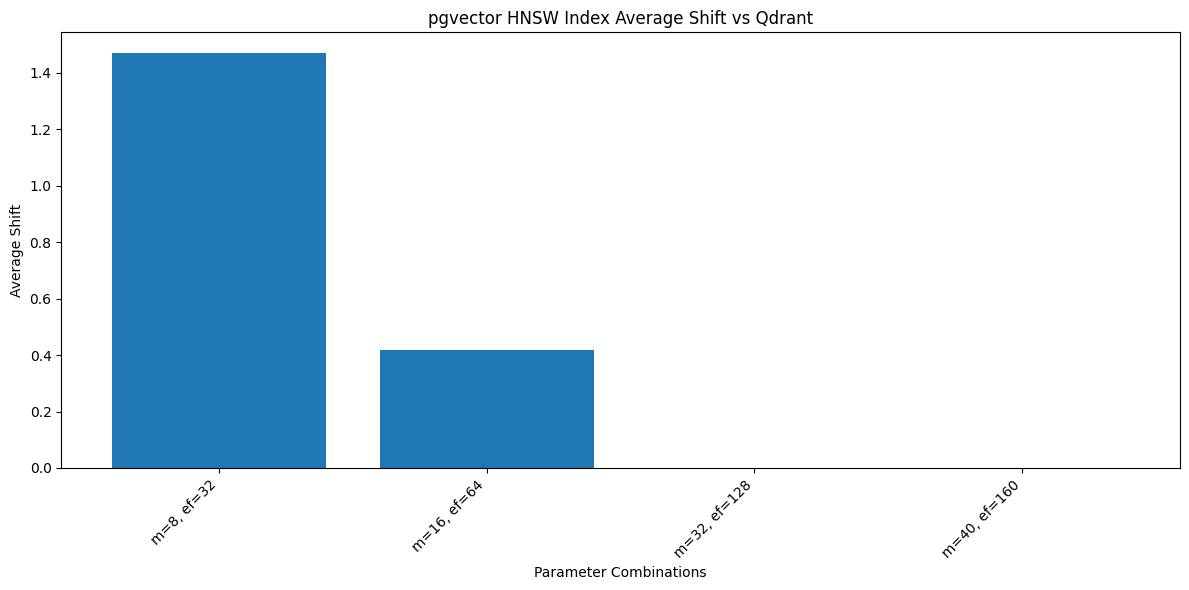

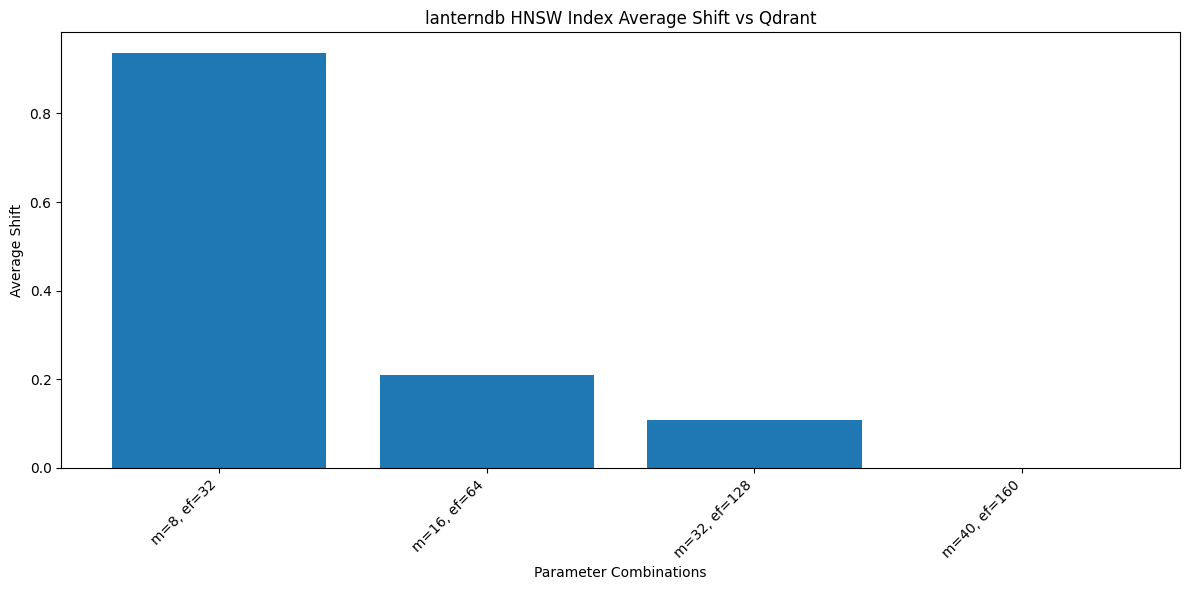

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store average shifts
pgvector_avg_shifts = []
lanterndb_avg_shifts = []

for m, ef in m_ef_pairs:
    pgvector_hnsw_result_shifts = []
    lanterndb_result_shifts = []

    qdrant_result_idx = 0
    for top_10 in qdrant_results:
        top_10_idx = 0
        for item in top_10:
            if item in pg_results_dict[(m, ef)]["pgvector"][qdrant_result_idx]:
                index_of_item = pg_results_dict[(m, ef)]["pgvector"][qdrant_result_idx].index(item)
                pgvector_hnsw_result_shifts.append(abs(index_of_item - top_10_idx))
            else:
                pgvector_hnsw_result_shifts.append(100)
            
            if item in pg_results_dict[(m, ef)]["lanterndb"][qdrant_result_idx]:
                index_of_item = pg_results_dict[(m, ef)]["lanterndb"][qdrant_result_idx].index(item)
                lanterndb_result_shifts.append(abs(index_of_item - top_10_idx))
            else:
                lanterndb_result_shifts.append(100)
                
            top_10_idx += 1
        qdrant_result_idx += 1

    # Calculate and store the average shifts
    pgvector_avg_shift = np.mean(pgvector_hnsw_result_shifts)
    lanterndb_avg_shift = np.mean(lanterndb_result_shifts)
    
    # Append the average shifts to the respective lists
    pgvector_avg_shifts.append(pgvector_avg_shift)
    lanterndb_avg_shifts.append(lanterndb_avg_shift)

plt.figure(figsize=(12, 6))
plt.bar(range(len(m_ef_pairs)), pgvector_avg_shifts, tick_label=[f"m={m}, ef={ef}" for m, ef in m_ef_pairs])
plt.xlabel("Parameter Combinations")
plt.ylabel("Average Shift")
plt.title("pgvector HNSW Index Average Shift vs Qdrant")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(range(len(m_ef_pairs)), lanterndb_avg_shifts, tick_label=[f"m={m}, ef={ef}" for m, ef in m_ef_pairs])
plt.xlabel("Parameter Combinations")
plt.ylabel("Average Shift")
plt.title("lanterndb HNSW Index Average Shift vs Qdrant")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
